![](Images/1.jpg)

![](Images/3.jpg)

IMPORTS

In [3]:
from calendar import weekday

#!pip install pvlib
#!pip install pandas
#!pip install ipywidgets

from IPython.display import display
import ipywidgets as widgets
import numpy as np # linear algebra
import pandas as pd
import pvlib
from datetime import datetime, timedelta

from jupyter_client.localinterfaces import is_public_ip
from pandas import DatetimeIndex
from pvlib.iotools import read_epw
import gym
from gym import spaces
from collections import defaultdict
import pickle
import matplotlib.pyplot as plt
import pygame
import sys
from collections import defaultdict
import torch.nn as nn
from torch import optim
import random
import torch
from collections import deque
import torch.nn.functional as F
from datetime import datetime, timedelta
import holidays

![](Images/4.jpg)

LOAD WEATHER DATA

In [4]:
# Read the EPW file
weather_data, meta = read_epw("istanbulWeather.epw")

# Preview the data
print(weather_data.head())
print(weather_data.columns.tolist())

# Access dry bulb temperature (°C)
temps = weather_data["temp_air"]
print(temps.head())
# Example: Print first 5 timestamps and temps
for i, (time, temp) in enumerate(temps.items()):
    if i >= 50:
        break
    print(f"{i}: {temp}")

                           year  month  day  hour  minute  \
1991-01-01 00:00:00+02:00  1991      1    1     1      60   
1991-01-01 01:00:00+02:00  1991      1    1     2      60   
1991-01-01 02:00:00+02:00  1991      1    1     3      60   
1991-01-01 03:00:00+02:00  1991      1    1     4      60   
1991-01-01 04:00:00+02:00  1991      1    1     5      60   

                                                       data_source_unct  \
1991-01-01 00:00:00+02:00  C9C9C9C9*0?9?9?9?9?9?9?9*0B8B8B8B8*0*0E8*0*0   
1991-01-01 01:00:00+02:00  C9C9C9C9*0?9?9?9?9?9?9?9A7A7A7A7A7A7*0E8*0*0   
1991-01-01 02:00:00+02:00  C9C9C9C9*0?9?9?9?9?9?9?9A7A7B8B8A7A7*0E8*0*0   
1991-01-01 03:00:00+02:00  C9C9C9C9*0?9?9?9?9?9?9?9A7A7B8B8A7A7*0E8*0*0   
1991-01-01 04:00:00+02:00  C9C9C9C9*0?9?9?9?9?9?9?9A7A7A7A7A7A7*0E8*0*0   

                           temp_air  temp_dew  relative_humidity  \
1991-01-01 00:00:00+02:00       5.4       4.0                 91   
1991-01-01 01:00:00+02:00       5.3       4.2 


> SET UP THE ROOM CONSTANTS AND GLOBAL VARIABLES









In [7]:
SURFACE_AREA = 9 #m^2
VOLUME = 27 #m^3
HEATER_OUTPUT = 500 #watt
AIR_HEAT_CAPACITY = 718 # J/kg.Kelvin
AIR_DENSITY = 1.3 #kg/m^3
U_CEILING = 0.4
U_FLOOR = 0.5
U_WALL = 0.6
HEAT_ON    = 0
COOL_ON    = 1
THERM_OFF  = 2


![](Images/8.png)

CALCULATE HEAT LOSS AND CHANGE IN TEMPRATURE

In [8]:
def calculate_heat_transfer(temp_outside, temp_inside):
    temp_diff = temp_inside - temp_outside
    heat_transfer_ceiling =  U_CEILING * SURFACE_AREA *(temp_diff)
    heat_transfer_floor = U_FLOOR * SURFACE_AREA *(temp_diff)
    heat_transfer_wall = U_WALL * 4 * SURFACE_AREA *(temp_diff)
    heat_transfer_total = heat_transfer_ceiling + heat_transfer_floor + heat_transfer_wall
    return heat_transfer_total

def calculate_change_in_temp(heat_change):
  change_in_temp = -(heat_change * 60)/(AIR_HEAT_CAPACITY * AIR_DENSITY * VOLUME)
  return change_in_temp

SET UP HELPER FUNCTIONS

In [10]:
def get_outside_temp(time):
    """Given a global minute count (0 to ~525600), return outside temperature."""
    H = len(temps)
    hour = (time // 60) % H             # wrap around
    next_hour = (hour + 1) % H
    frac = time % 60
    delta = (temps.iloc[next_hour] - temps.iloc[hour]) / 60

    return round(temps.iloc[hour] + delta * frac, 0)

def get_time_bin(time, interval_minutes=15):
    """
    Given a global minute count (0 to ~525600), return time bin string like '08:15'.
    """
    minute_of_day = time % 1440  # 1440 minutes in a day
    bin_minute = (minute_of_day // interval_minutes) * interval_minutes
    return f"{bin_minute // 60:02d}:{bin_minute % 60:02d}"


In [13]:


turkey_holidays = holidays.country_holidays("TR", years=range(1991, 2100))
def is_working_hours(total_minutes):
    """
    Check if the time is within working hours (08:00–18:00),
    not on a weekend, and not a public holiday in Turkey.
    """
    base_date = datetime(1991, 1, 1)
    current_datetime = base_date + timedelta(minutes=total_minutes)

    minute_of_day = current_datetime.hour * 60 + current_datetime.minute
    is_weekend = current_datetime.weekday() >= 5  # 5=Saturday, 6=Sunday
    is_public_holiday = current_datetime.date() in turkey_holidays

    return not is_weekend and not is_public_holiday and 480 <= minute_of_day < 1080

In [15]:

# Define Turkish holidays using the country code
turkey_holidays = holidays.country_holidays("TR", years=range(1991, 2100))
def what_day(episode):
    """
    Check if the time is within working hours (08:00–18:00),
    not on a weekend, and not a public holiday in Turkey.
    """
    base_date = datetime(1991, 1, 1)
    current_datetime = base_date + timedelta(days=(episode%365)-1)
    is_weekend = current_datetime.weekday() >= 5  # 5=Saturday, 6=Sunday
    is_public_holiday = current_datetime.date() in turkey_holidays
    day=current_datetime.weekday()
    weekDay = ""
    if day==0:
        weekDay = "Monday"
    elif day==1:
        weekDay = "Tuesday"
    elif day==2:
        weekDay = "Wednesday"
    elif day==3:
        weekDay = "Thursday"
    elif day==4:
        weekDay = "Friday"
    elif day==5:
        weekDay = "Saturday"
    elif day==6:
        weekDay = "Sunday"
    else:
        weekDay = "Error"
    #print(f"it is {weekDay}")
    #print(f"it is {current_datetime.date()}")
    #if is_public_holiday:
        #holiday = turkey_holidays.get(current_datetime.date())
       # print(f"public holiday in Turkey: {holiday}")
    return weekDay, is_public_holiday, current_datetime.date()

In [18]:
what_day(1)

('Tuesday', True, datetime.date(1991, 1, 1))

BAYSEAN OCCUPANCY PREDICTOR

In [19]:
class BayesianOccupancyPredictor:
    def __init__(self):
        # Dictionary to store probabilities and experience count for each time slot (e.g. "08:00", "08:15")
        self.occupancy_probs = {}
        self.experience_counts = {}

    def initialize_slot(self, time_slot):
        """Initialize the time slot if not already present."""
        if time_slot not in self.occupancy_probs:
            self.occupancy_probs[time_slot] = {
                'occupied': 0.5,       # Initial prior (50/50)
                'not_occupied': 0.5
            }
            self.experience_counts[time_slot] = 0

    def update(self, time_slot, observed_occupied):
        """Update the probabilities based on a new observation."""
        self.initialize_slot(time_slot)

        prob = self.occupancy_probs[time_slot]
        expc = self.experience_counts[time_slot]
        expc_prime = expc + 1

        if observed_occupied:
            prob['occupied'] = (prob['occupied'] * expc + 1) / expc_prime
            prob['not_occupied'] = (prob['not_occupied'] * expc) / expc_prime
        else:
            prob['occupied'] = (prob['occupied'] * expc) / expc_prime
            prob['not_occupied'] = (prob['not_occupied'] * expc + 1) / expc_prime

        self.experience_counts[time_slot] = expc_prime

    def predict(self, time_slot):
        """Return the current probability of occupancy."""
        self.initialize_slot(time_slot)
        return self.occupancy_probs[time_slot]['occupied']

    def print_state(self):
        """Print all learned occupancy probabilities."""
        for slot, probs in sorted(self.occupancy_probs.items()):
            print(f"{slot}: P(occupied)={probs['occupied']:.3f}, P(not_occupied)={probs['not_occupied']:.3f}")

    def calculate_tto(self, current_time, threshold=0.6, lookahead_bins=8, bin_interval=15):
      """Calculate the time to occupancy"""
      for i in range(1, lookahead_bins + 1):
          future_time = current_time + i * bin_interval  # Just add minutes
          time_bin = get_time_bin(future_time)           # Convert to 'HH:MM' bin
          prob = self.predict(time_bin)                  # Lookup predicted occupancy
          if prob >= threshold:
              return i * bin_interval
      return lookahead_bins * bin_interval




![](Images/5.jpg)
![](Images/6.jpg)

DEFINE THE ENVIRONMENT

In [20]:
class MyHvacEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(
            low=np.array([-8.0, 0.0, -8.0]),
            high=np.array([32.0, 120.0, 32.0]),
            dtype=np.float32
        )
        self.low = self.observation_space.low
        self.high = self.observation_space.high
        self.bayesian_predictor = BayesianOccupancyPredictor()
        self.step_count = 0
        self.reset(0)

    def reset(self, day):
        self.time = day * 1440
        self.step_count = 0
        self.ot = get_outside_temp(self.time)
        self.rt = self.ot
        self.tto = self.bayesian_predictor.calculate_tto(self.time)
        self.state = np.array([self.rt, self.tto, self.ot], dtype=np.float32)
        return self.state


    def step(self, action):
        self.time += 1
        self.bayesian_predictor.update(
            get_time_bin(self.time),
            is_working_hours(self.time)
        )

        rt, tto, ot = self.state
        conduction = calculate_heat_transfer(ot, rt)
        heat_change = conduction

        if action == HEAT_ON:
            heat_change -= HEATER_OUTPUT
        elif action == COOL_ON:
            heat_change += HEATER_OUTPUT

        delta_temp = calculate_change_in_temp(heat_change)
        self.rt = np.clip(round(rt + delta_temp, 0), self.low[0], self.high[0])
        self.tto = self.bayesian_predictor.calculate_tto(self.time)
        self.ot = get_outside_temp(self.time)

        self.state = np.array([self.rt, self.tto, self.ot], dtype=np.float32)
        reward = self.get_reward(action)
        self.step_count += 1
        terminated = self.time % 1440 == 0  # End of day
        truncated = False

        return self.state, reward, terminated, truncated, {}

    def get_reward(self, action):
        rt, tto, ot = self.state
        occupied = is_working_hours(self.time)
        setpoint = 23.0
        threshold = 2

        if occupied and abs(rt - setpoint) <= threshold:
            return 30
        elif occupied and abs(rt - setpoint) > threshold:
            return -15
        elif tto >= 60 and action in [HEAT_ON, COOL_ON]:
            return -10
        elif action == HEAT_ON and (rt > setpoint or ot > setpoint):
            return -7
        elif action == COOL_ON and (rt < setpoint or ot < setpoint):
            return -7
        else:
            return 0

    def render(self):
        pass

    def close(self):
        pass


In [22]:
class NormalizedQNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.register_buffer('mean', torch.tensor([12.0, 60.0, 12.0]))
        self.register_buffer('scale', torch.tensor([20.0, 60.0, 20.0]))
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = (x - self.mean) / self.scale  # Normalization
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


In [23]:
class DuelingQNet(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, output_dim=3):
        super(DuelingQNet, self).__init__()

        # Common feature layer
        self.feature = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )

        # Value stream
        self.value_stream = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

        # Advantage stream
        self.advantage_stream = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x = self.feature(x)
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        # Combine value and advantage streams
        q_values = value + advantage - advantage.mean(dim=1, keepdim=True)
        return q_values


In [24]:
class DuelingQNetP(nn.Module):
    def __init__(self, input_dim=3, output_dim=3):
        super(DuelingQNetP, self).__init__()
        self.feature = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU()
        )
        self.value_stream = nn.Linear(12, 1)
        self.advantage_stream = nn.Linear(12, output_dim)

    def forward(self, x):
        x = self.feature(x)
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        return value + advantage - advantage.mean(dim=1, keepdim=True)


![](Images/9.png)

In [25]:
def train_dqnP():
    env = MyHvacEnv()
    policy_net = DuelingQNetP()
    target_net = DuelingQNetP()
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.Adam(policy_net.parameters(), lr=0.0001)
    memory = deque(maxlen=100000)

    # Exploration parameters from the paper
    GAMMA = 0.99
    EPSILON_START = 1.0
    EPSILON_END = 0.2
    EPSILON_DECAY = 0.9995

    episode_rewards = []
    episode_losses = []
    temperature_logs = defaultdict(lambda: {
        'timesteps': [],
        'room_temp': [],
        'outside_temp': []
    })

    training_days = list(range(365))

    for episode in range(10000):
        if episode % 365 == 0:
            random.shuffle(training_days)
        day = training_days[episode % 365]
        state = torch.from_numpy(env.reset(day=day)).float()

        epsilon = max(EPSILON_END, EPSILON_START * (EPSILON_DECAY ** episode))
        ep_reward = 0
        ep_loss = 0
        step_count = 0

        for _ in range(1440):  # simulate full day
            # Epsilon-greedy policy
            if random.random() < epsilon:
                action = random.randint(0, 2)
            else:
                with torch.no_grad():
                    action = policy_net(state.unsqueeze(0)).argmax().item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            reward = max(-1.0, min(1.0, reward * 0.01))  # Keep this simple
            done = terminated or truncated
            next_state = torch.from_numpy(next_state).float()

            memory.append((state, action, reward, next_state, done))
            ep_reward += reward

            # Train
            if len(memory) >= 5000:
                batch = random.sample(memory, 256)
                states, actions, rewards, next_states, dones = zip(*batch)
                states = torch.stack(states)
                actions = torch.LongTensor(actions)
                rewards = torch.FloatTensor(rewards)
                next_states = torch.stack(next_states)
                dones = torch.BoolTensor(dones)

                current_q = policy_net(states).gather(1, actions.unsqueeze(1))
                next_q = target_net(next_states).max(1)[0].detach()
                target = rewards + GAMMA * next_q * (~dones)

                loss = F.smooth_l1_loss(current_q.squeeze(), target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                ep_loss += loss.item()
                step_count += 1

            # Log temperature
            temp_log = temperature_logs[episode]
            temp_log['timesteps'].append(env.time)
            temp_log['room_temp'].append(env.rt)
            temp_log['outside_temp'].append(env.ot)

            state = next_state

        episode_rewards.append(ep_reward)
        episode_losses.append(ep_loss / step_count if step_count > 0 else 0)

        if episode % 100 == 0:
            print(f"Episode {episode}: Reward={ep_reward:.2f}, Loss={ep_loss:.2f}")

        if episode % 50 == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if episode % 2000 == 0:
            torch.save(policy_net.state_dict(), f"DuelingD3QN_paper_{episode}.pth")
            with open(f"logs_paper_{episode}.pkl", "wb") as f:
                pickle.dump({
                    "episode_rewards": episode_rewards,
                    "episode_losses": episode_losses,
                    "temperature_logs": dict(temperature_logs),
                    "predictor": env.bayesian_predictor
                }, f)

    # Final save
    torch.save(policy_net.state_dict(), "D3QN/Models/DuelingD3QN_paper_final.pth")
    with open("D3QN/Logs/logs_paper_final.pkl", "wb") as f:
        pickle.dump({
            "episode_rewards": episode_rewards,
            "episode_losses": episode_losses,
            "temperature_logs": dict(temperature_logs),
            "predictor": env.bayesian_predictor
        }, f)

    plot_training_metrics(episode_rewards, episode_losses)
    plot_temperature_for_episode(temperature_logs, target_episode=9354)


In [217]:

def train_dqn():
    env = MyHvacEnv()
    policy_net = DuelingQNet()
    target_net = DuelingQNet()
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.Adam(policy_net.parameters(), lr=0.00001)
    memory = deque(maxlen=100000)

    # Hyperparameters from tabular version
    GAMMA = 0.99
    EPSILON_START = 1.0
    EPSILON_END = 0.01
    EPSILON_DECAY = 0.9999

    episode_rewards = []
    episode_losses = []
    temperature_logs = defaultdict(lambda: {
        'timesteps': [],
        'room_temp': [],
        'outside_temp': []
    })

    training_days = list(range(365))



    for episode in range(10000):  # 10,000 episodes = ~27 years
        if episode % 365 == 0:
            random.shuffle(training_days)
        day = training_days[episode % 365]
        state = env.reset(day=day)
        state = torch.FloatTensor(state)
        epsilon = max(EPSILON_END, EPSILON_START * (EPSILON_DECAY ** episode))
        ep_reward = 0
        ep_loss = 0
        step_count = 0
        for _ in range(1440):  # Full day simulation
            # Epsilon-greedy action selection (like tabular)
            if random.random() < epsilon:
                action = random.randint(0, 2)
            else:
                with torch.no_grad():
                    action = policy_net(state.unsqueeze(0)).argmax().item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            # At the end of step()
            reward = max(-1.0, min(1.0, reward * 0.01))

            done = terminated or truncated
            next_state = torch.FloatTensor(next_state)
            memory.append((state, action, reward, next_state, done))
            ep_reward += reward

            # Train with experience replay
            if len(memory) >= 1440*5:
                batch = random.sample(memory, 256)
                states, actions, rewards, next_states, dones = zip(*batch)

                # Convert to tensors
                states = torch.stack(states)
                actions = torch.LongTensor(actions)
                rewards = torch.FloatTensor(rewards)
                next_states = torch.stack(next_states)
                dones = torch.BoolTensor(dones)

                # Compute Q-values
                current_q = policy_net(states).gather(1, actions.unsqueeze(1))
                next_q = target_net(next_states).max(1)[0].detach()
                target = rewards + GAMMA * next_q * (~dones)

                # Optimize
                loss = F.smooth_l1_loss(current_q.squeeze(), target)
                if torch.isnan(loss):
                    print(f"**********NaN loss at episode {episode}**************")

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                loss_val = loss.item()
                ep_loss += loss_val
                step_count += 1

            temp_log = temperature_logs[episode]
            temp_log['timesteps'].append(env.time)
            temp_log['room_temp'].append(env.rt)
            temp_log['outside_temp'].append(env.ot)


            state = next_state
        episode_rewards.append(ep_reward)
        if step_count > 0:
            episode_losses.append(ep_loss / step_count)
        else:
            episode_losses.append(0)


        if episode % 100 ==0 :
             print(f"Episode {episode}: Reward={ep_reward:.2f}, Loss={ep_loss:.2f}")
        # Update target network periodically
        if episode % 50 == 0:
            target_net.load_state_dict(policy_net.state_dict())
        if episode % 2000 == 0:
        # Save model and logs
            torch.save(policy_net.state_dict(), f"DuelingD3QN4{episode}.pth")
            logs = {
                "episode_rewards": episode_rewards,
                "episode_losses": episode_losses,
                "temperature_logs": dict(temperature_logs),  # convert defaultdict to dict
                "predictor": env.bayesian_predictor
            }
            with open(f"training_logsD3QN4{episode}.pkl", "wb") as f:
                pickle.dump(logs, f)
    print("Training complete. Generating plots...")
    torch.save(policy_net.state_dict(), f"DuelingD3QN4.pth")

     # Save logs
    logs = {
        "episode_rewards": episode_rewards,
        "episode_losses": episode_losses,
        "temperature_logs": dict(temperature_logs),  # convert defaultdict to dict
        "predictor": env.bayesian_predictor
    }
    with open("D3QN/Logs/training_logsD3QN4.pkl", "wb") as f:
        pickle.dump(logs, f)
    plot_training_metrics(episode_rewards, episode_losses)
    plot_temperature_for_episode(temperature_logs, target_episode=100)




In [26]:
def plot_training_metrics(episode_rewards, episode_losses):
    plt.figure(figsize=(15, 10))
    # Reward plot
    plt.subplot(2, 2, 1)
    plt.plot(episode_rewards)
    plt.title('Total Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True)

    # Loss plot
    plt.subplot(2, 2, 2)
    plt.plot(episode_losses)
    plt.title('Average Loss per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.grid(True)

    # Moving average reward
    plt.subplot(2, 2, 3)
    window = max(1, len(episode_rewards) // 20)
    moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
    plt.plot(moving_avg)
    plt.title(f'Moving Average Reward (Window={window})')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True)

    # Reward distribution
    plt.subplot(2, 2, 4)
    plt.hist(episode_rewards, bins=30)
    plt.title('Reward Distribution')
    plt.xlabel('Reward')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()


def plot_temperature_for_episode(temperature_logs, target_episode):
    log = temperature_logs.get(target_episode)
    weekDay, is_public_holiday, date = what_day(target_episode)
    if not log or not log['timesteps']:
        print(f"No temperature data found for episode {target_episode}")
        return

    plt.figure(figsize=(12, 6))

    # Convert timesteps to hours
    hours = [(t % 1440) / 60 for t in log['timesteps']]


    plt.plot(hours, log['room_temp'], 'r-', label='Room Temperature')
    plt.plot(hours, log['outside_temp'], 'b-', label='Outside Temperature')

    # Highlight working hours
    working_start = 8
    working_end = 18
    plt.axvspan(working_start, working_end, alpha=0.2, color='green', label='Working Hours')

    plt.title(f'Temperature Profile - Day {date} ({weekDay})')
    plt.xlabel('Time (Hours)')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [219]:
#train_dqn()

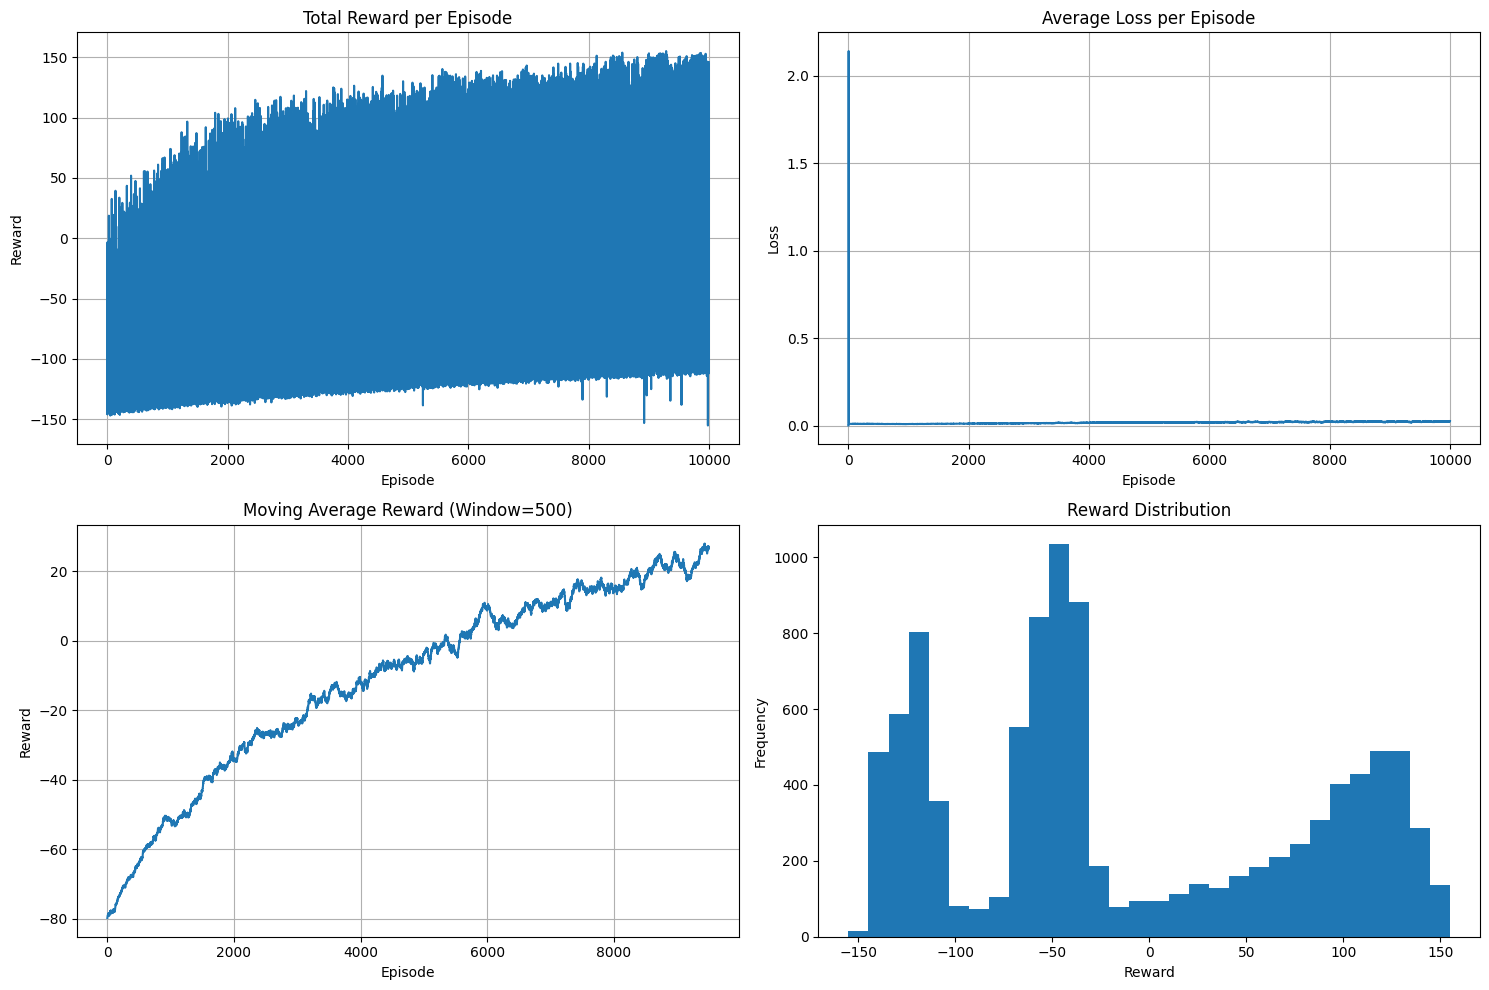

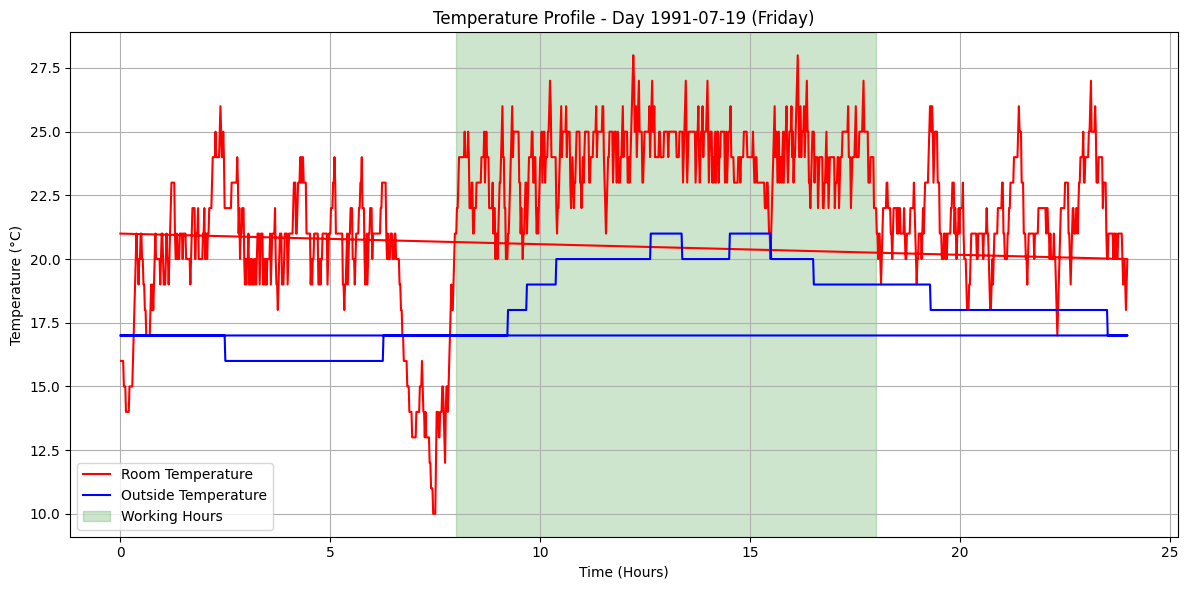

In [31]:
with open("D3QN/Logs/training_logsD3QN4.pkl", "rb") as f:
    logs = pickle.load(f)
plot_training_metrics(logs['episode_rewards'], logs['episode_losses'])
plot_temperature_for_episode(logs['temperature_logs'], target_episode=7500)


PLOT


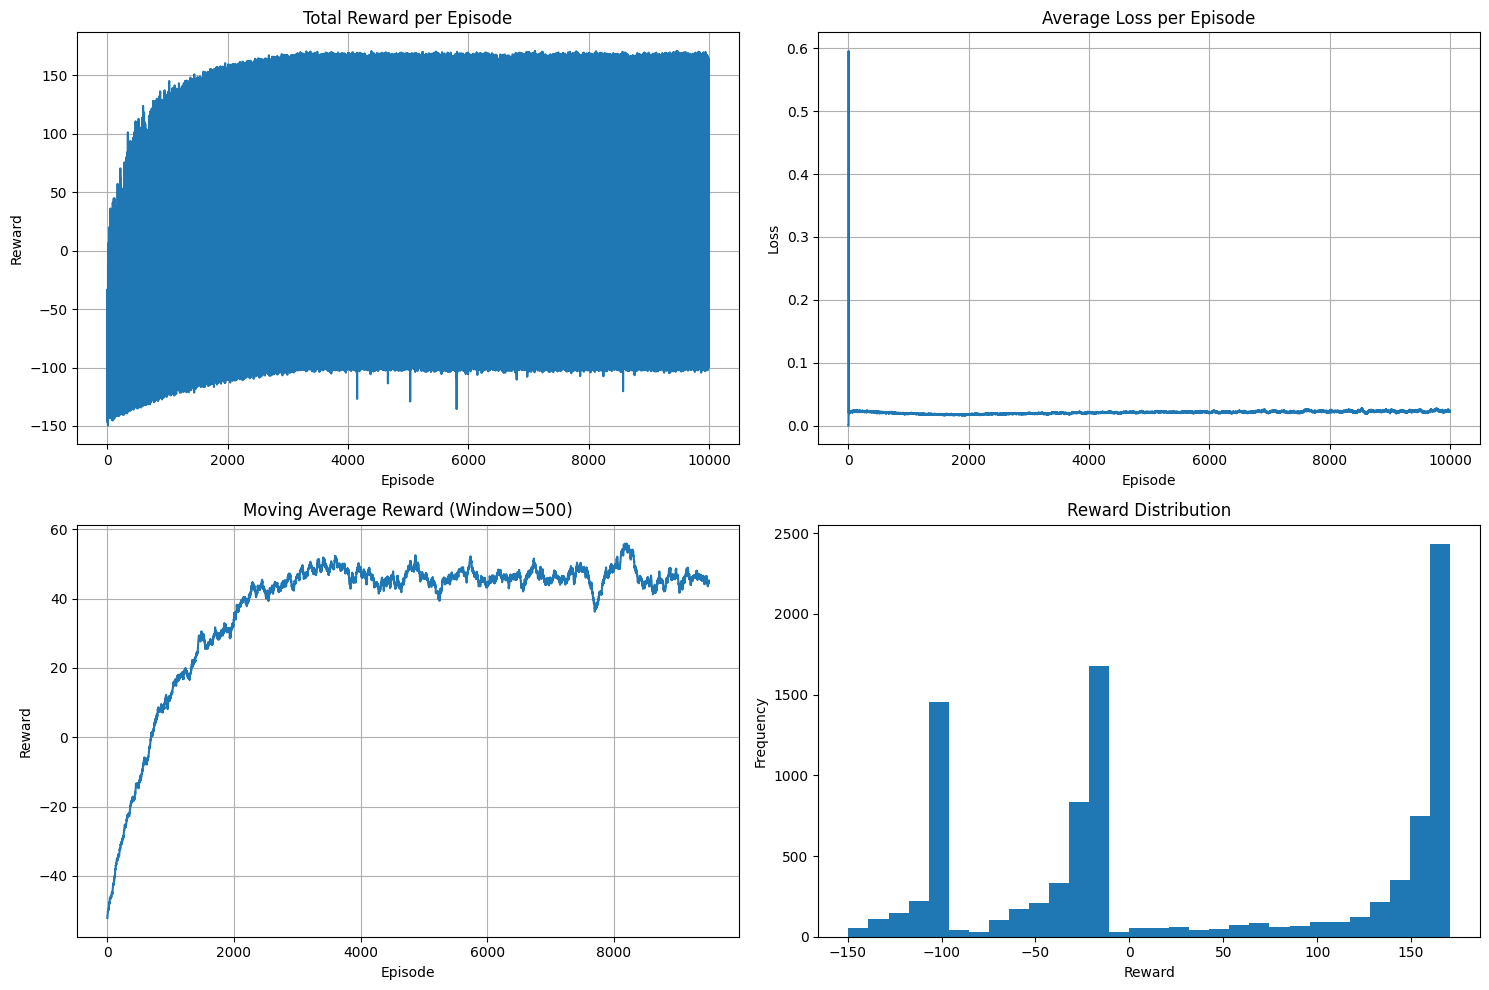

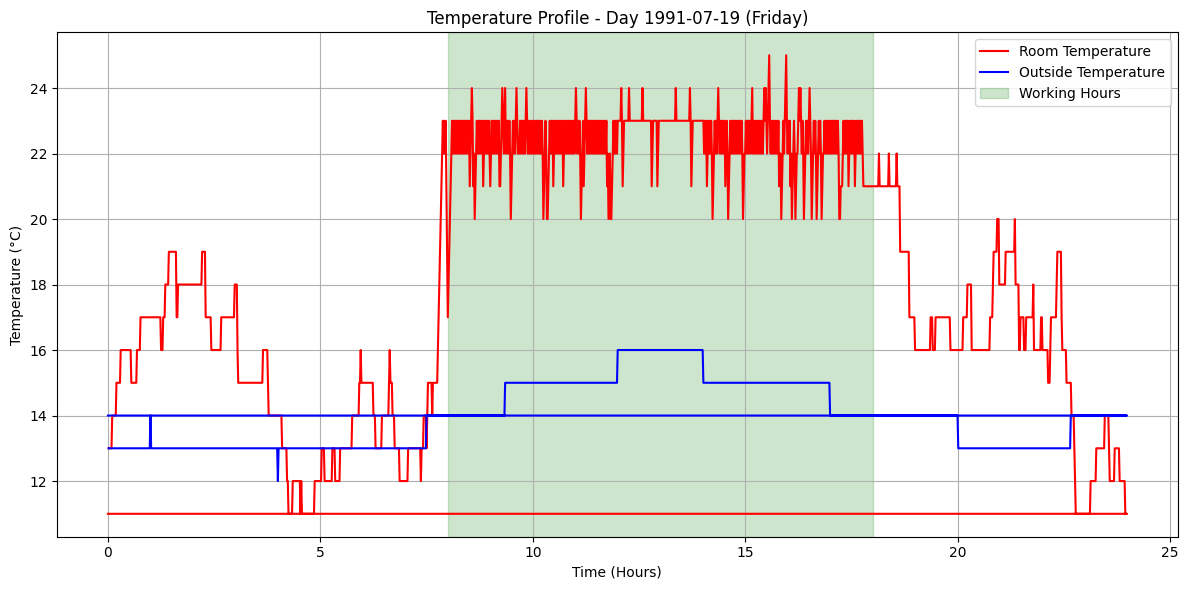

In [32]:
with open("D3QN/Logs/logs_paper_final.pkl", "rb") as f:
    logs = pickle.load(f)
plot_training_metrics(logs['episode_rewards'], logs['episode_losses'])
plot_temperature_for_episode(logs['temperature_logs'], target_episode=7500)

In [33]:
# -------------------------------
# 1. Interactive Day Picker Widget
# -------------------------------

def interactive_day_plot(logs):
    max_day = max(logs.keys())

    day_selector = widgets.IntSlider(value=0, min=1, max=max_day, step=1, description='Day:')
    output = widgets.Output()

    def update_plot(change):
        with output:
            output.clear_output(wait=True)
            plot_temperature_for_episode(logs, day_selector.value)

    day_selector.observe(update_plot, names='value')

    display(day_selector, output)
    update_plot(None)  # initial plot

In [34]:
interactive_day_plot(logs['temperature_logs'])


IntSlider(value=1, description='Day:', max=9999, min=1)

Output()

SIMULATE

In [36]:
def simulate_day(episode):
    model_path = "D3QN/Models/DuelingD3QN_paper_final.pth"  # Adjust as needed
    logs_path = "D3QN/Logs/logs_paper_final.pkl"  # Adjust as needed
    weekDay, is_public_holiday, date = what_day(episode)
    # Load model and predictor
    policy_net = DuelingQNetP()
    policy_net.load_state_dict(torch.load(model_path))
    policy_net.eval()


    with open(logs_path, "rb") as f:
        logs = pickle.load(f)
    predictor = logs["predictor"]

    env = MyHvacEnv()
    env.bayesian_predictor = predictor

    # Use reset with episode=day to initialize time and temps properly
    state = env.reset(day=episode)
    # Update TTO explicitly since reset does that as well
    env.tto = predictor.calculate_tto(env.time)
    env.state = np.array([env.rt, env.tto, env.ot], dtype=np.float32)

    pygame.init()
    WIDTH, HEIGHT = 800, 600
    screen = pygame.display.set_mode((WIDTH, HEIGHT))
    pygame.display.set_caption("DQN Day Simulation")
    font = pygame.font.SysFont(None, 28)
    clock = pygame.time.Clock()

    running = True
    paused = False
    step_index = 0

    def temp_color(temp):
        if temp < 20:
            return (0, 0, 255)
        elif temp > 25:
            return (255, 0, 0)
        else:
            return (0, 255, 0)

    def draw(state, action, reward):
        screen.fill((245, 245, 245))
        rt, tto, ot = state

        ot_size = np.interp(ot, [env.low[2], env.high[2]], [100, 400])
        ot_color = temp_color(ot)
        ot_rect = pygame.Rect(WIDTH//2 - ot_size//2, HEIGHT//2 - ot_size//2, ot_size, ot_size)
        pygame.draw.rect(screen, ot_color, ot_rect, width=4)

        rt_size = np.interp(rt, [env.low[0], env.high[0]], [50, ot_size-20])
        rt_color = temp_color(rt)
        rt_rect = pygame.Rect(WIDTH//2 - rt_size//2, HEIGHT//2 - rt_size//2, rt_size, rt_size)
        pygame.draw.rect(screen, rt_color, rt_rect)

        occ = is_working_hours(env.time)
        tri_color = (255, 165, 0) if occ else (128, 128, 128)
        cx, cy = WIDTH//2, HEIGHT//2
        size = rt_size / 3
        points = [
            (cx, cy - size / 2),
            (cx - size / 2, cy + size / 2),
            (cx + size / 2, cy + size / 2)
        ]
        pygame.draw.polygon(screen, tri_color, points)

        labels = [
            f"Holiday: {'Yes' if is_public_holiday else 'No'}",
            f"Day: {weekDay} {date}",
            f"Time: {env.time//60 % 24:02d}:{env.time % 60:02d}",
            f"Room Temp: {env.rt:.1f}°C",
            f"Outside Temp: {env.ot:.1f}°C",
            f"TTO: {env.tto:.1f} min",
            f"Action: {['Heat On','Cool On','Off'][action]}",
            f"Reward: {reward:.1f}",
            f"Occupied: {'Yes' if occ else 'No'}"

        ]
        for i, txt in enumerate(labels):
            surf = font.render(txt, True, (15, 15, 15))
            screen.blit(surf, (40, 40 + i * 30))

        pygame.display.flip()

    while running:
        clock.tick(15 if not paused else 3)

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_SPACE:
                    paused = not paused
                elif event.key == pygame.K_RIGHT:
                    episode += 1
                    state = env.reset(day=episode)
                    env.tto = predictor.calculate_tto(env.time)
                    env.state = np.array([env.rt, env.tto, env.ot], dtype=np.float32)
                    step_index = 0
                elif event.key == pygame.K_LEFT:
                    episode = max(0, episode - 1)
                    state = env.reset(day=episode)
                    env.tto = predictor.calculate_tto(env.time)
                    env.state = np.array([env.rt, env.tto, env.ot], dtype=np.float32)
                    step_index = 0
                weekDay, is_public_holiday, date = what_day(episode)

        if not paused and running:
            env.bayesian_predictor.update(get_time_bin(env.time), is_working_hours(env.time))
            env.tto = predictor.calculate_tto(env.time)
            state = np.array([env.rt, env.tto, env.ot], dtype=np.float32)
            state_tensor = torch.FloatTensor(state).unsqueeze(0)

            with torch.no_grad():
                action = policy_net(state_tensor).argmax().item()
            state, reward, terminated, truncated, _ = env.step(action)
            draw(state, action, reward)
            step_index += 1

            if step_index >= 1440 or terminated:
                paused = True

    pygame.quit()
    return


In [38]:
simulate_day(7500)

/Users/melika/PycharmProjects/HVAC-Q-Learning/.venv1/lib/python3.13/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
